## Setting up the Imports

- numpy will be handy for mathematical functions.
- matplotlib will be used for the visualisation of the maze. 

In [26]:
import numpy as np
import matplotlib.pyplot as plt

## Setting up the Maze

- Using matplotplib we use arrays filled with zeros (open space) and ones (walls) to build the maze structure. 
- In here, we also define the positions of the starting area, the end goal, and the sub goal. 

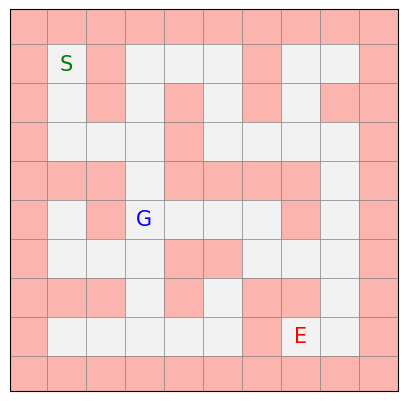

In [27]:
# Initialising the maze
class Maze:
    def __init__(self, maze, start_position, goal_position, sub_goal_position):
        self.maze = maze
        
        self.maze_width = maze_struc.shape[1]           # rows of maze, also knows as x-azis. 
        self.maze_height = maze_struc.shape[0]          # columns of maze, also known as y-axis.

        self.start_position = start_position            # start position - S.
        self.goal_position = goal_position              # end goal position - E.
        self.sub_goal_position = sub_goal_position      # sub goal position - G.

    def show_maze(self):
        plt.figure(figsize=(5,5))

        plt.imshow(self.maze, cmap='Pastel1_r')

        # Placements for the start, end, and sub goal positions.
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='green', fontsize=15)
        plt.text(self.goal_position[0], self.goal_position[1], 'E', ha='center', va='center', color='red', fontsize=15)
        plt.text(self.sub_goal_position[0], self.sub_goal_position[1], 'G', ha='center', va='center', color='blue', fontsize=15)

        # Add grid lines between every wall/space.
        plt.grid(color='black', linestyle='-', linewidth=0.5)
        plt.xticks(np.arange(0.5, self.maze.shape[1], 1))
        plt.yticks(np.arange(0.5, self.maze.shape[0], 1))
        plt.gca().set_xticks(np.arange(-0.5, self.maze.shape[1], 1), minor=True)
        plt.gca().set_yticks(np.arange(-0.5, self.maze.shape[0], 1), minor=True)
        plt.gca().grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
        plt.gca().tick_params(which='both', length=0)

        plt.xlim(-0.45, self.maze.shape[1] - 0.5)
        plt.ylim(self.maze.shape[0] - 0.6, -0.4)

        # Hide the digits and labels from the plot visualistion. 
        plt.xticks([]), plt.yticks([])

        # Ensures the plot will visualise when running the code.
        plt.show()


# The layout of the 10x10 maze:
# 1 = wall.
# 0 = open area.
# (If wanted, we can later make another file where we can generate larger mazes like 100x100).
maze_struc = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

# Places the start, end, and sub goal at the correct coordinates (rows, columns).
maze = Maze(maze_struc, (1, 1), (7, 8), (3,5))

# Actually visualises the plot with matplotlib.
maze.show_maze()

## Setting up the Agent

This is where the logic of the agent come in:
- The agent can move in four directions. These are up, down, left, and right. 
- The q learning formula and logic will be applied to it. The parameters the agent will go off are:
    - the learning rate → decides how much new information overrides over information.
    - the discount factor → decides if the agent will prefer better rewards later on, or smaller awards right away
    - exploration rate → exploration vs. exploitation. This code works with a decay, over time it will proper exploitation over exploration in the maze.

- The agent is based on this formula of Q-Learning:

$$ Q(s, a) ← Q(s, a) + α [r + γ max(a') Q(s', a') - Q(s, a)] $$

In [28]:
# Actions the agent can take.
moves = [
   (-1, 0),         # Moving one step up.
   (1, 0),          # Moving one step down.
   (0, -1),         # Moving one step left.
   (0, 1)           # Moving one step right.
]

# Initialise the Q-Learning agent 
class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.9, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        
        # The table gets updated as new information is stored. 4 stands for the actions the agent can take. 
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4)) 
         
        self.learning_rate = learning_rate          
        self.discount_factor = discount_factor      
        self.exploration_start = exploration_start  
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    # Calculates the rate of exploration to exploitation over time -> start with a lot of exploration and eventually prefer exploitation.
    def get_exploration_rate(self, current_episode):
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate
    
    # Chooses what movement action to make. 
    def get_action(self, state, current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)

        # Select an action for the given state either randomly (exploration) or using the Q-table (exploitation).
        if np.random.rand() < exploration_rate:
            return np.random.randint(4) 
        else:
            #Chooses the action with the highest Q-value for the given state.
            return np.argmax(self.q_table[state]) 
        
    # Updates the Q-values in the Q-table based on its actions and states.
    def update_q_table(self, state, action, next_state, reward):
        best_next_action = np.argmax(self.q_table[next_state])

        current_q_value = self.q_table[state][action]

        # Formula to update the Q-value based on the theory of the Q-Learning algorithm.
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)

        # Apply new Q-value for current action and state. 
        self.q_table[state][action] = new_q_value


## Setting up Agent in Maze

This cell will show the behaviour of the agent in a single episode and before it is trained with the Q-Learning algorithm.

- It DOES define the logic on the agent inside of the maze. In other words, giving the agent rewards and penalities for hitting walls and reaching the goal, respectively.
- So, it keeps track of the total reward.
- It also tracks the total steps the agent took.
- It also updates the Q-values as necessary.

Below, we first initialise the rewards or penalties the agent will receive based on its behaviour. Change as needed.

In [29]:
goal_reward = 100
sub_goal_reward = 50

wall_penalty = -10
step_penalty = -1

In [52]:
def finish_episode(agent, maze, current_episode, train=True):

    current_state = maze.start_position     # Agent starts at start position.
    path = [current_state]                  # Tracks the agent's current position.

    goal_reached = False                    # Tracks if the agent reached the goal.
    sub_reached = False                     # Tracks if the agent reached the sub goal.

    episode_reward = 0                      # Tracks the agent's total award at the end of the episode.
    episode_step = 0                        # Tracks the agent's total steots at the end of the episode.
    

    while not goal_reached:

        # Decides the next agent's next action based on the Q-Table.
        action = agent.get_action(current_state, current_episode)
        next_state = (current_state[0] + moves[action][0], current_state[1] + moves[action][1])

        # Give a penalty is a wall is hit.
        if (next_state[0] < 0 or next_state[0] >= maze.maze_height or 
            next_state[1] < 0 or next_state[1] >= maze.maze_width or 
            maze.maze[next_state[1]][next_state[0]]) == 1:
            reward = wall_penalty
            next_state = current_state

        # Give a single-time reward is the sub goal is reached.
        elif next_state == (maze.sub_goal_position) and not sub_reached:
            path.append(current_state)
            reward = sub_goal_reward
            sub_reached = True

        # Mark that agent has reached the end and give reward.
        elif next_state == (maze.goal_position):
            path.append(current_state)
            reward = goal_reward
            goal_reached = True

        # Give a penalty every time the agent takes a step without it being at the final goal position.
        else:
            path.append(current_state)
            reward = step_penalty

        # Keeps track of the total steps and reward.
        episode_reward += reward
        episode_step += 1

        # Updates Q-table is set to True.
        if train == True:
            agent.update_q_table(current_state, action, next_state, reward)

        # Looping through this will cause agent to take a next action/step.
        current_state = next_state

    # Shows total reward, steps and the path it took.
    return episode_reward, episode_step, path

## Visualising the Agent Test

Final Path:
(1, 1)-> (1, 1)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (2, 3)-> (3, 3)-> (2, 3)-> (1, 3)-> (2, 3)-> (1, 3)-> (1, 2)-> (1, 3)-> (1, 2)-> (1, 3)-> (2, 3)-> (1, 3)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 1)-> (1, 2)-> (1, 3)-> (2, 3)-> (3, 3)-> (3, 4)-> (3, 3)-> (3, 2)-> (3, 1)-> (3, 2)-> (3, 1)-> (3, 2)-> (3, 3)-> (3, 4)-> (3, 5)-> (3, 6)-> (3, 5)-> (4, 5)-> (5, 5)-> (4, 5)-> (5, 5)-> (4, 5)-> (5, 5)-> (4, 5)-> (5, 5)-> (4, 5)-> (3, 5)-> (3, 6)-> (3, 5)-> (3, 4)-> (3, 5)-> (3, 4)-> (3, 3)-> (3, 4)-> (3, 5)-> (3, 4)-> (3, 5)-> (3, 6)-> (3, 5)-> (3, 6)-> (3, 5)-> (4, 5)-> (3, 5)-> (3, 4)-> (3, 5)-> (3, 6)-> (2, 6)-> (1, 6)-> (2, 6)-> (1, 6)-> (2, 6)-> (3, 6)-> (3, 7)-> (3, 6)-> (3, 5)-> (4, 5)-> (3, 5)-> (3, 6)-> (3, 7)-> (3, 6)-> (3, 7)-> (3, 8)-> (3, 7)-> (3, 6)-> (3, 5)-> (3, 6)-> (2, 6)-> (1, 6)-> (1, 5)-> (1, 6)-> (1, 5)-> (1, 6)-> (1, 5)-> (1, 6)-> (1, 5)-> (1, 6)-> (2, 6)-> (1, 6)-> (2, 6)-> (1, 6)-> (2, 6)-> (3, 6)-> (3, 7)-> (3, 8)-> (2, 8)-> (3, 8)-> (2, 8)-

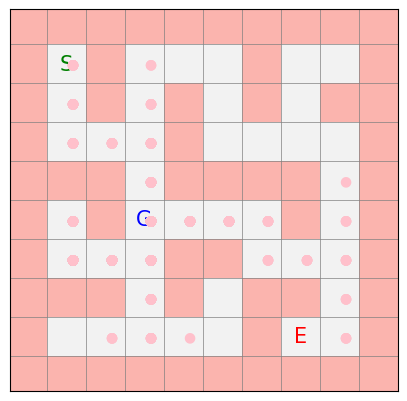

(613, -3125)

In [53]:
def test_agent(agent, maze, num_episodes=1):
  
    episode_reward, episode_step, path = finish_episode(agent, maze, num_episodes, train=False)

    print("Final Path:")
    for row, col in path:
        print(f"({row}, {col})-> ", end='')
    print("End Reached.")

    print("Total steps:", episode_step)
    print("Total reward:", episode_reward)

    # Visualise the maze like before again.
    plt.figure(figsize=(5, 5))
    plt.imshow(maze.maze, cmap='Pastel1_r')

    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='green', fontsize=15)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'E', ha='center', va='center', color='red', fontsize=15)
    plt.text(maze.sub_goal_position[0], maze.sub_goal_position[1], 'G', ha='center', va='center', color='blue', fontsize=15)

    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(0.5, maze.maze.shape[1], 1))
    plt.yticks(np.arange(0.5, maze.maze.shape[0], 1))
    plt.gca().set_xticks(np.arange(-0.5, maze.maze.shape[1], 1), minor=True)
    plt.gca().set_yticks(np.arange(-0.5, maze.maze.shape[0], 1), minor=True)
    plt.gca().grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
    plt.gca().tick_params(which='both', length=0)

    plt.xlim(-0.45, maze.maze.shape[1] - 0.5)
    plt.ylim(maze.maze.shape[0] - 0.6, -0.4)

    # Additionally show the path the agent took.
    for position in path:
        plt.text(position[0], position[1], "●", va='center', color='pink', fontsize=10)

    plt.xticks([]), plt.yticks([])
    plt.show(block=True) 

    return episode_step, episode_reward

agent = QLearningAgent(maze)
test_agent(agent, maze)